In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor, early_stopping, log_evaluation, plot_importance
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
import warnings
import optuna

warnings.filterwarnings('ignore')

c:\Users\jiahe\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
test = pd.read_csv(r"C:\Users\jiahe\OneDrive\Desktop\kaggle\test.csv")
train = pd.read_csv(r"C:\Users\jiahe\OneDrive\Desktop\kaggle\train.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (517754, 14)
Test shape: (172585, 13)


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [3]:
train.isnull().sum().sort_values(ascending=False).head(10)

id                    0
road_type             0
num_lanes             0
curvature             0
speed_limit           0
lighting              0
weather               0
road_signs_present    0
public_road           0
time_of_day           0
dtype: int64

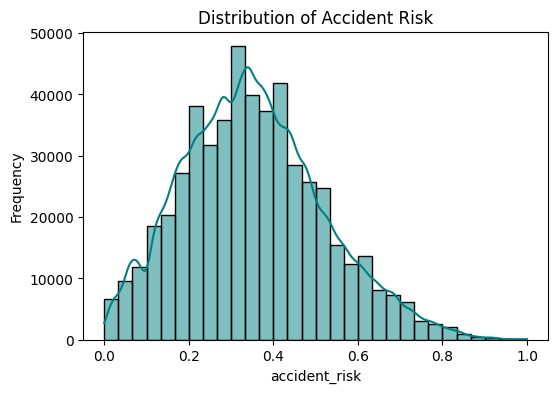

In [4]:
plt.figure(figsize=(6,4))
sns.histplot(train['accident_risk'], bins=30, kde=True, color='teal')
plt.title("Distribution of Accident Risk")
plt.xlabel("accident_risk")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Identify categorical columns
cat_cols = train.select_dtypes(include=['object']).columns
print("Categorical columns:", list(cat_cols))

# Inspect high-risk weather distribution
high_risk = train[train['accident_risk'] > 0.8]
print("\nWeather distribution among high-risk accidents:")
print(high_risk['weather'].value_counts(normalize=True))

# Boxplot: Accident risk by weather condition
plt.figure(figsize=(8,4))
sns.boxplot(x='weather', y='accident_risk', data=train, palette='pastel')
plt.title("Accident Risk by Weather Condition")
plt.xlabel("Weather")
plt.ylabel("Accident Risk")
plt.xticks(rotation=30)
plt.show()

In [ ]:
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop(['id', 'accident_risk'])
train[num_cols].describe()

plt.figure(figsize=(10,8))
mask = np.triu(np.ones_like(train[num_cols].corr(), dtype=bool))
sns.heatmap(train[num_cols].corr(), mask=mask, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(x='time_of_day', y='accident_risk', data=train, order=['morning','afternoon','evening'])
plt.title("Accident Risk by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Accident Risk")
plt.show()

# if you want average risk per time bucket:
mean_risk_by_time = train.groupby('time_of_day')['accident_risk'].mean().sort_values()
print(mean_risk_by_time)

In [ ]:
# Select only numeric columns (exclude id and target)
num_cols = train.select_dtypes(include=['int64', 'float64']).columns.drop(['id', 'accident_risk'])

# Compute correlation of each numeric column with the target
corrs = train[num_cols].corrwith(train['accident_risk']).sort_values(ascending=False)

# Display top correlations
print("\nTop numeric features correlated with accident_risk:\n")
print(corrs)

# Plot the top 10 for clarity
plt.figure(figsize=(7,5))
corrs.head(10).plot(kind='barh', color='teal')
plt.title("Top 10 Numeric Features Correlated with Accident Risk")
plt.xlabel("Correlation Coefficient")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# numeric columns except id/target
num_cols = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=train[col], color='lightblue')
    plt.title(f"Outlier Check: {col}")
    plt.show()

    # quick stats summary
    print(f"{col} - min: {train[col].min():.2f}, 99th percentile: {train[col].quantile(0.99):.2f}, max: {train[col].max():.2f}")

In [ ]:
num_cols = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.kdeplot(train[col], label='train', fill=True, common_norm=False)
    sns.kdeplot(test[col], label='test', fill=True, common_norm=False)
    plt.title(f"Train vs Test Distribution: {col}")
    plt.legend()
    plt.show()

In [5]:
train_cat = train.copy()
test_cat = test.copy()

cat_cols = ['road_type', 'lighting', 'weather', 'time_of_day']

for col in cat_cols:
    categories = pd.Categorical(pd.concat([train_cat[col], test_cat[col]], axis=0)).categories
    train_cat[col] = pd.Categorical(train_cat[col], categories=categories)
    test_cat[col] = pd.Categorical(test_cat[col], categories=categories)

In [6]:
# List of categorical columns to target encode
target_encode_cols = ['road_type', 'lighting', 'weather', 'time_of_day']

# Initialize KFold for target encoding
kf = KFold(n_splits=5, shuffle=True, random_state=42)
encoded_features = pd.DataFrame(index=train.index)

for col in target_encode_cols:
    print(f"Target encoding: {col}")
    oof = pd.Series(np.nan, index=train.index)

    # Create out-of-fold mean for each category
    for train_idx, val_idx in kf.split(train):
        means = train.iloc[train_idx].groupby(col)['accident_risk'].mean()
        oof.iloc[val_idx] = train.iloc[val_idx][col].astype(str).map(means)


    encoded_features[col + '_te'] = oof

# Add encoded features to train
train = pd.concat([train, encoded_features], axis=1)

# Apply same encoding (using full-train mean) to test
for col in target_encode_cols:
    global_mean = train.groupby(col)['accident_risk'].mean()
    test[col + '_te'] = test[col].astype(str).map(global_mean)

Target encoding: road_type
Target encoding: lighting
Target encoding: weather
Target encoding: time_of_day


In [7]:
X = train_cat.drop(columns=['id', 'accident_risk'])
y = train_cat['accident_risk']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
model_fs = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_fs.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',
    callbacks=[early_stopping(100)]
)

# Compute feature importance
importance_df = pd.DataFrame({
    'feature': X.columns,
    'gain': model_fs.booster_.feature_importance(importance_type='gain')
}).sort_values('gain', ascending=False)

# Filter weak features
threshold = importance_df['gain'].median() * 0.1  # keep features above 10% of median gain
selected_features = importance_df.query('gain > @threshold')['feature'].tolist()

print(f"Selected {len(selected_features)} / {len(X.columns)} features")

# Reduce the dataset to selected features
X = X[selected_features]
test_X = test_cat[selected_features]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 12
[LightGBM] [Info] Start training from score 0.352605
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[997]	valid_0's rmse: 0.0562706	valid_0's l2: 0.00316638
Selected 12 / 12 features


In [9]:
def objective(trial):
    params = {
        "n_estimators": 8000,
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.05, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 50, 200),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 200),
        "random_state": 42,
        "n_jobs": -1,
        "verbosity": -1
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = LGBMRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric="rmse",
            callbacks=[optuna.integration.LightGBMPruningCallback(trial, "rmse")]
        )
        preds = model.predict(X_val)
        mse = mean_squared_error(y_val, preds)
        rmse = np.sqrt(mse)
        rmse_scores.append(rmse)
        
    return np.mean(rmse_scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40, show_progress_bar=True)

print("Best RMSE:", study.best_value)
print("Best Params:", study.best_params)

best_params = study.best_params

[I 2025-10-21 11:38:50,025] A new study created in memory with name: no-name-29f8f882-5fa0-473c-8f54-f4e45ea9698a
Best trial: 0. Best value: 0.0560782:   2%|▎         | 1/40 [04:09<2:42:09, 249.47s/it]

[I 2025-10-21 11:42:59,485] Trial 0 finished with value: 0.056078162525734845 and parameters: {'learning_rate': 0.005560138318903602, 'num_leaves': 168, 'max_depth': 10, 'subsample': 0.8612568323499717, 'colsample_bytree': 0.6173913627297224, 'reg_alpha': 0.6935791577063481, 'reg_lambda': 0.3899200537641332, 'min_child_samples': 167}. Best is trial 0 with value: 0.056078162525734845.


Best trial: 1. Best value: 0.0560762:   5%|▌         | 2/40 [05:59<1:45:52, 167.17s/it]

[I 2025-10-21 11:44:49,044] Trial 1 finished with value: 0.05607616440212605 and parameters: {'learning_rate': 0.012461319813908984, 'num_leaves': 159, 'max_depth': 9, 'subsample': 0.709756400551474, 'colsample_bytree': 0.7916434549454494, 'reg_alpha': 0.7493525336967382, 'reg_lambda': 0.22084587740006323, 'min_child_samples': 161}. Best is trial 1 with value: 0.05607616440212605.


Best trial: 1. Best value: 0.0560762:   8%|▊         | 3/40 [07:43<1:25:26, 138.55s/it]

[I 2025-10-21 11:46:33,534] Trial 2 finished with value: 0.056182934085867366 and parameters: {'learning_rate': 0.038042965232379926, 'num_leaves': 67, 'max_depth': 4, 'subsample': 0.6945145601788997, 'colsample_bytree': 0.6880762483670814, 'reg_alpha': 0.3442223525909487, 'reg_lambda': 0.7610410921999445, 'min_child_samples': 92}. Best is trial 1 with value: 0.05607616440212605.


Best trial: 3. Best value: 0.0560317:  10%|█         | 4/40 [09:05<1:09:39, 116.11s/it]

[I 2025-10-21 11:47:55,240] Trial 3 finished with value: 0.05603169204752214 and parameters: {'learning_rate': 0.021641505628742737, 'num_leaves': 186, 'max_depth': 10, 'subsample': 0.7246836163613158, 'colsample_bytree': 0.7496822900577432, 'reg_alpha': 0.6479738901840086, 'reg_lambda': 0.2456161223218749, 'min_child_samples': 24}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  12%|█▎        | 5/40 [10:07<56:27, 96.79s/it]   

[I 2025-10-21 11:48:57,772] Trial 4 finished with value: 0.05605533045997289 and parameters: {'learning_rate': 0.032373949268840824, 'num_leaves': 120, 'max_depth': 10, 'subsample': 0.6057076551003502, 'colsample_bytree': 0.6348321375876395, 'reg_alpha': 0.9823618196360397, 'reg_lambda': 0.20985463628788303, 'min_child_samples': 52}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  15%|█▌        | 6/40 [10:07<36:14, 63.95s/it]

[I 2025-10-21 11:48:57,976] Trial 5 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  18%|█▊        | 7/40 [10:08<23:44, 43.17s/it]

[I 2025-10-21 11:48:58,353] Trial 6 pruned. Trial was pruned at iteration 45.


Best trial: 3. Best value: 0.0560317:  20%|██        | 8/40 [10:08<15:43, 29.49s/it]

[I 2025-10-21 11:48:58,561] Trial 7 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  22%|██▎       | 9/40 [10:12<11:06, 21.51s/it]

[I 2025-10-21 11:49:02,518] Trial 8 pruned. Trial was pruned at iteration 914.


Best trial: 3. Best value: 0.0560317:  25%|██▌       | 10/40 [10:12<07:28, 14.94s/it]

[I 2025-10-21 11:49:02,734] Trial 9 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  28%|██▊       | 11/40 [10:12<05:02, 10.44s/it]

[I 2025-10-21 11:49:02,965] Trial 10 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  30%|███       | 12/40 [10:13<03:25,  7.33s/it]

[I 2025-10-21 11:49:03,188] Trial 11 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  32%|███▎      | 13/40 [12:35<21:39, 48.14s/it]

[I 2025-10-21 11:51:25,236] Trial 12 finished with value: 0.05605475575000931 and parameters: {'learning_rate': 0.03036411612598568, 'num_leaves': 96, 'max_depth': 8, 'subsample': 0.6493933809284756, 'colsample_bytree': 0.6542165167727897, 'reg_alpha': 0.8613051869403671, 'reg_lambda': 0.5137566896104666, 'min_child_samples': 20}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  35%|███▌      | 14/40 [12:39<15:06, 34.85s/it]

[I 2025-10-21 11:51:29,371] Trial 13 pruned. Trial was pruned at iteration 1238.


Best trial: 3. Best value: 0.0560317:  38%|███▊      | 15/40 [12:39<10:10, 24.41s/it]

[I 2025-10-21 11:51:29,602] Trial 14 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  40%|████      | 16/40 [12:42<07:07, 17.80s/it]

[I 2025-10-21 11:51:32,033] Trial 15 pruned. Trial was pruned at iteration 484.


Best trial: 3. Best value: 0.0560317:  42%|████▎     | 17/40 [12:42<04:47, 12.51s/it]

[I 2025-10-21 11:51:32,248] Trial 16 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  45%|████▌     | 18/40 [12:42<03:14,  8.82s/it]

[I 2025-10-21 11:51:32,482] Trial 17 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  48%|████▊     | 19/40 [12:42<02:10,  6.24s/it]

[I 2025-10-21 11:51:32,697] Trial 18 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  50%|█████     | 20/40 [15:29<18:09, 54.50s/it]

[I 2025-10-21 11:54:19,678] Trial 19 finished with value: 0.056083112883613104 and parameters: {'learning_rate': 0.035244855674321625, 'num_leaves': 130, 'max_depth': 7, 'subsample': 0.6392088895602704, 'colsample_bytree': 0.6444247118348346, 'reg_alpha': 0.3029183790165588, 'reg_lambda': 0.44307255151536123, 'min_child_samples': 20}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  52%|█████▎    | 21/40 [15:29<12:05, 38.20s/it]

[I 2025-10-21 11:54:19,888] Trial 20 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  55%|█████▌    | 22/40 [17:54<21:03, 70.17s/it]

[I 2025-10-21 11:56:44,618] Trial 21 finished with value: 0.0560577885375401 and parameters: {'learning_rate': 0.03252939166475381, 'num_leaves': 116, 'max_depth': 9, 'subsample': 0.6277860418242281, 'colsample_bytree': 0.6367943210759005, 'reg_alpha': 0.9088738038498237, 'reg_lambda': 0.25646223021723646, 'min_child_samples': 52}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  57%|█████▊    | 23/40 [17:54<13:56, 49.19s/it]

[I 2025-10-21 11:56:44,848] Trial 22 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  60%|██████    | 24/40 [17:55<09:12, 34.50s/it]

[I 2025-10-21 11:56:45,093] Trial 23 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  62%|██████▎   | 25/40 [17:57<06:12, 24.85s/it]

[I 2025-10-21 11:56:47,418] Trial 24 pruned. Trial was pruned at iteration 313.


Best trial: 3. Best value: 0.0560317:  65%|██████▌   | 26/40 [20:08<13:15, 56.80s/it]

[I 2025-10-21 11:58:58,777] Trial 25 finished with value: 0.05605103386400484 and parameters: {'learning_rate': 0.049738635642229016, 'num_leaves': 121, 'max_depth': 10, 'subsample': 0.6777576599926012, 'colsample_bytree': 0.672796478505418, 'reg_alpha': 0.7742206788800655, 'reg_lambda': 0.47498937499782046, 'min_child_samples': 31}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  68%|██████▊   | 27/40 [22:26<17:35, 81.19s/it]

[I 2025-10-21 12:01:16,880] Trial 26 finished with value: 0.056048967130232254 and parameters: {'learning_rate': 0.049846181926191196, 'num_leaves': 144, 'max_depth': 9, 'subsample': 0.6827607839545884, 'colsample_bytree': 0.666623983521703, 'reg_alpha': 0.7889078150047633, 'reg_lambda': 0.46043525035426947, 'min_child_samples': 29}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  70%|███████   | 28/40 [24:45<19:39, 98.30s/it]

[I 2025-10-21 12:03:35,106] Trial 27 finished with value: 0.05605105776139596 and parameters: {'learning_rate': 0.04865871442758174, 'num_leaves': 163, 'max_depth': 10, 'subsample': 0.7173208380293526, 'colsample_bytree': 0.6758032080754431, 'reg_alpha': 0.7579575392758088, 'reg_lambda': 0.44095149867067407, 'min_child_samples': 35}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  72%|███████▎  | 29/40 [26:58<19:58, 108.92s/it]

[I 2025-10-21 12:05:48,796] Trial 28 finished with value: 0.05606634726125624 and parameters: {'learning_rate': 0.04144553925503343, 'num_leaves': 181, 'max_depth': 9, 'subsample': 0.7608244162312476, 'colsample_bytree': 0.7261210704179554, 'reg_alpha': 0.6124386085666995, 'reg_lambda': 0.4360839043019321, 'min_child_samples': 131}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  75%|███████▌  | 30/40 [26:59<12:43, 76.31s/it] 

[I 2025-10-21 12:05:49,015] Trial 29 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  78%|███████▊  | 31/40 [26:59<08:01, 53.50s/it]

[I 2025-10-21 12:05:49,278] Trial 30 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  80%|████████  | 32/40 [29:14<10:24, 78.02s/it]

[I 2025-10-21 12:08:04,510] Trial 31 finished with value: 0.05605106783507097 and parameters: {'learning_rate': 0.049692240338238526, 'num_leaves': 164, 'max_depth': 10, 'subsample': 0.7208064054610586, 'colsample_bytree': 0.671033537266821, 'reg_alpha': 0.6686605609406404, 'reg_lambda': 0.45285254584779544, 'min_child_samples': 34}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  82%|████████▎ | 33/40 [31:30<11:08, 95.53s/it]

[I 2025-10-21 12:10:20,901] Trial 32 finished with value: 0.056049517339009904 and parameters: {'learning_rate': 0.04944461401840763, 'num_leaves': 168, 'max_depth': 10, 'subsample': 0.7045808158507474, 'colsample_bytree': 0.681372173412617, 'reg_alpha': 0.7446150334045684, 'reg_lambda': 0.595284150089666, 'min_child_samples': 30}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  85%|████████▌ | 34/40 [33:49<10:50, 108.37s/it]

[I 2025-10-21 12:12:39,214] Trial 33 finished with value: 0.05604938724881037 and parameters: {'learning_rate': 0.037679565602924056, 'num_leaves': 199, 'max_depth': 10, 'subsample': 0.6991268598261368, 'colsample_bytree': 0.697964878243766, 'reg_alpha': 0.7675884916563791, 'reg_lambda': 0.594179452138483, 'min_child_samples': 50}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  88%|████████▊ | 35/40 [36:11<09:52, 118.49s/it]

[I 2025-10-21 12:15:01,328] Trial 34 finished with value: 0.05604639033049954 and parameters: {'learning_rate': 0.03734669879227801, 'num_leaves': 198, 'max_depth': 10, 'subsample': 0.6987373345406391, 'colsample_bytree': 0.6922772070305238, 'reg_alpha': 0.6695093804160583, 'reg_lambda': 0.6197316164430215, 'min_child_samples': 49}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  90%|█████████ | 36/40 [38:46<08:38, 129.59s/it]

[I 2025-10-21 12:17:36,823] Trial 35 finished with value: 0.05604805919777779 and parameters: {'learning_rate': 0.03744669862783953, 'num_leaves': 200, 'max_depth': 9, 'subsample': 0.6982519590709141, 'colsample_bytree': 0.7013471571985803, 'reg_alpha': 0.5289963901343195, 'reg_lambda': 0.676924227053605, 'min_child_samples': 52}. Best is trial 3 with value: 0.05603169204752214.


Best trial: 3. Best value: 0.0560317:  92%|█████████▎| 37/40 [38:47<04:32, 90.78s/it] 

[I 2025-10-21 12:17:37,052] Trial 36 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  95%|█████████▌| 38/40 [38:47<02:07, 63.62s/it]

[I 2025-10-21 12:17:37,289] Trial 37 pruned. Trial was pruned at iteration 0.


Best trial: 3. Best value: 0.0560317:  98%|█████████▊| 39/40 [38:48<00:44, 44.92s/it]

[I 2025-10-21 12:17:38,594] Trial 38 pruned. Trial was pruned at iteration 157.


Best trial: 3. Best value: 0.0560317: 100%|██████████| 40/40 [38:48<00:00, 58.22s/it]

[I 2025-10-21 12:17:38,819] Trial 39 pruned. Trial was pruned at iteration 0.
Best RMSE: 0.05603169204752214
Best Params: {'learning_rate': 0.021641505628742737, 'num_leaves': 186, 'max_depth': 10, 'subsample': 0.7246836163613158, 'colsample_bytree': 0.7496822900577432, 'reg_alpha': 0.6479738901840086, 'reg_lambda': 0.2456161223218749, 'min_child_samples': 24}


In [10]:
# Set up 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
test_X = test_cat.drop(columns=['id'])
test_preds_all = np.zeros(len(test_X))

In [11]:
# === Define models ===
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\n===== Fold {fold + 1} / {kf.n_splits} =====")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Align columns to avoid mismatch
    X_val = X_val[X_train.columns]
    test_X = test_X[X_train.columns]

    # === LightGBM model (stable tuned version) ===
    model_lgb = LGBMRegressor(
        **study.best_params,
        n_estimators=12000,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )

    # === XGBoost model (stable tuned version) ===
    model_xgb = XGBRegressor(
        n_estimators=10000,
        learning_rate=0.018,
        max_depth=7,
        min_child_weight=3,
        subsample=0.75,
        colsample_bytree=0.75,
        reg_alpha=0.3,
        reg_lambda=0.8,
        random_state=42,
        tree_method='hist',
        eval_metric='rmse',
        objective='reg:squarederror',
        early_stopping_rounds=300,
        enable_categorical=True,
        n_jobs=-1
    )

    # === Train models ===
    model_lgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        categorical_feature=cat_cols,
        callbacks=[early_stopping(200), log_evaluation(0)]
    )

    model_xgb.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # === Predict & blend ===
    val_preds_lgb = model_lgb.predict(X_val)
    val_preds_xgb = model_xgb.predict(X_val)
    val_preds = 0.55 * val_preds_lgb + 0.45 * val_preds_xgb

    rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse:.5f}")

    # === Predict on test and accumulate average ===
    test_pred_lgb = model_lgb.predict(test_X)
    test_pred_xgb = model_xgb.predict(test_X)
    test_preds_all += 0.5 * (test_pred_lgb + test_pred_xgb) / kf.n_splits



===== Fold 1 / 5 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[647]	valid_0's rmse: 0.0561753	valid_0's l2: 0.00315566
Fold 1 RMSE: 0.05617

===== Fold 2 / 5 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[749]	valid_0's rmse: 0.0560451	valid_0's l2: 0.00314106
Fold 2 RMSE: 0.05603

===== Fold 3 / 5 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[730]	valid_0's rmse: 0.0560945	valid_0's l2: 0.00314659
Fold 3 RMSE: 0.05608

===== Fold 4 / 5 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[542]	valid_0's rmse: 0.0559205	valid_0's l2: 0.0031271
Fold 4 RMSE: 0.05592

===== Fold 5 / 5 =====
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[678]	valid_0's rmse: 0.0558711	valid_0's l2: 0.00312158
Fold 5 RMSE: 0.05586


In [12]:
# Average RMSE
avg_rmse = np.mean(rmse_scores)
print("\n============================")
print(f"✅ Average RMSE across folds: {avg_rmse:.5f}")
print("============================")


✅ Average RMSE across folds: 0.05601


In [13]:
# Save final averaged predictions
submission = pd.DataFrame({
    'id': test_cat['id'],
    'accident_risk': test_preds_all
})
submission.to_csv('submission_kfold.csv', index=False)
print("✅ submission_kfold.csv ready for Kaggle upload!")

✅ submission_kfold.csv ready for Kaggle upload!
